In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
from collections import defaultdict


from datetime import datetime
from datetime import timedelta

In [9]:
# store map size (pixels)
STORE_SIZE = [3136, 2475]

# re-id area size
RE_ID_ORIGIN_POINT = [1080, 1280]
RE_ID_AREA = [335, 690]

# occlusion area [xmin, ymin, xmax, ymax]
OCCLUSION_AREA = [1130, 1400, 1415, 1675]

# Enter/Exit defined areas
# BL - Bottom Left / R - Right / T - Top / TL - Top Left
ENTER_EXIT_AREAS = {"BL":[1075, 1250, 1150, 1325], "R":[1400, 1250, 1435, 1960], "T":[1205, 1960, 1435, 1970], "TL":[1075, 1825, 1205, 1970]}

# distance and time interval of first iteration (merge close points)
DISTANCE_CLOSE = 10
TIME_INTERVAL_CLOSE = 5

# distance and time interval of second iteration
DISTANCE = 100
TIME_INTERVAL = 30

# average walking speed
AVG_WALKING_SPEED = 30 #pixels per second

# example number 
EXAMPLE_NUMBER = 25

# load and saving paths
TRAJECTORY_EXAMPLE_PATH = f"data_examples_third_exp/example_{EXAMPLE_NUMBER}/"
TRAJECTORY_DATA_PATH = "results/trajectories/transformed_coords.csv"
MAP_PATH = "C:/Users/diogo/Desktop/Tese/Dados/floorplan with area.png"
INFO_SAVE_PATH = f"data_examples_third_exp/example_{EXAMPLE_NUMBER}/info_{EXAMPLE_NUMBER}.txt"


In [10]:
# restrict the area of the points in the dataset
def get_data_reid_area(df):
    df_filtered = df[(df["x_floorplan_new"] >= RE_ID_ORIGIN_POINT[0]) & 
                     (df["x_floorplan_new"] <= RE_ID_ORIGIN_POINT[0] + RE_ID_AREA[0]) & 
                     (df["y_floorplan_new"] >= RE_ID_ORIGIN_POINT[1]) & 
                     (df["y_floorplan_new"] <= RE_ID_ORIGIN_POINT[1] + RE_ID_AREA[1])]
    return df_filtered


# remove points (from camera 1.03) affect by occlusions in an area overlapped by 2 cameras
def remove_data_occlusion_area(df):
    df_filtered = df[
        (df["camera"] != 1.03) |
        ((df["camera"] == 1.03) &
         ((df["x_floorplan_new"] <= OCCLUSION_AREA[0]) |
          (df["x_floorplan_new"] >= OCCLUSION_AREA[2]) |
          (df["y_floorplan_new"] <= OCCLUSION_AREA[1]) |
          (df["y_floorplan_new"] >= OCCLUSION_AREA[3])))]
    return df_filtered


# remove points generated by false positive person detections by the object detector
def remove_false_positive_data(df):
    for customer in df.customer_id_global.unique():
        customer_rows = df[df["customer_id_global"] == customer]

        x_value = customer_rows["x_floorplan_new"].iloc[0].astype(int)
        y_value = customer_rows["y_floorplan_new"].iloc[0].astype(int)
        
        if (customer_rows["x_floorplan_new"].between(x_value - 1, x_value + 1, inclusive=True)).all() and (customer_rows["y_floorplan_new"].astype(int).between(y_value - 1, y_value + 1, inclusive=True)).all():
            df = df[df["customer_id_global"] != customer]
 
    return df


# returns the data time interval
def get_time_interval(df):
    min_time = df["time"].min()
    max_time = df["time"].max()
    return (min_time, max_time)


# returns the last point of each customer
def get_customers_last_point(df):
    for customer in df.customer_id_global.unique():
        all_except_last = df.loc[df["customer_id_global"] == customer].sort_values(by='time').iloc[:-1].index
        df = df.drop(all_except_last)
    return df


# returns the first point of each customer
def get_customers_first_point(df):
    for customer in df.customer_id_global.unique():
        all_except_first = df.loc[df["customer_id_global"] == customer].sort_values(by='time').iloc[1:].index
        df = df.drop(all_except_first)
    return df


# returns a boolean:
#       - True if the given point is inside a Exit/Entry area
#       - False otherwise
def is_in_EE_area(x, y):
    areas = ["BL", "R", "T", "TL"]
    for area in areas:
        if (ENTER_EXIT_AREAS[area][0] < x < ENTER_EXIT_AREAS[area][2]) and (ENTER_EXIT_AREAS[area][1] < y < ENTER_EXIT_AREAS[area][3]):
            return True
    return False


# return the eligible points based on their location
def get_eligible_points(df):
    for index, row in df.iterrows():
        if is_in_EE_area(row["x_floorplan_new"], row["y_floorplan_new"]):
            df = df.drop(index)
    return df

# return points in a given time interval
def get_similar_time_points(df, time, time_interval, is_first_reid):
    if is_first_reid:
        begin_time = str((datetime.strptime(time,"%H:%M:%S")).time())
    else:
        begin_time = str((datetime.strptime(time,"%H:%M:%S") - timedelta(seconds=time_interval)).time())
    end_time = str((datetime.strptime(time,"%H:%M:%S") + timedelta(seconds=time_interval)).time())
    return df.loc[(df["time"] > begin_time) & (df["time"] < end_time)]


# return the closest point to the last customer point
# note: this is applied after filter points by time
def get_closest_customer(df, x, y, time, max_dist = None):
    closest_customer = pd.DataFrame()
    for index, row in df.iterrows():
        distance = math.dist((x, y), (row["x_floorplan_new"], row["y_floorplan_new"])) 

        if max_dist is None:     
            time_interval = int((datetime.strptime(row["time"], "%H:%M:%S") - (datetime.strptime(time,"%H:%M:%S"))).seconds)
            max_dist = calculate_max_distance(time_interval, AVG_WALKING_SPEED)

        if distance < max_dist:
            if closest_customer.empty or distance < math.dist((x, y), (closest_customer["x_floorplan_new"], closest_customer["y_floorplan_new"])):
                closest_customer = row

    return closest_customer


# return the max distance that a trajectory point can be, given a time interval
def calculate_max_distance(time_interval, walk_speed):
    return time_interval * walk_speed
    

# first re-identification: 
# re-identifies the customers that are close to each order, in order to avoid errors caused by detection and tracking algorithms
def re_id_customers_close_points(df, distance, time_interval):
    df.sort_values(by="time")
    df.loc[:, "need_reid"] = "yes"
    for index, row in df.iterrows():
        df_without_self = df.loc[df["customer_id_global"] != row["customer_id_global"]]
        points_need_reid = df_without_self.loc[df_without_self["need_reid"] == "yes"]
        if not points_need_reid.empty:
            similiar_time = get_similar_time_points(points_need_reid, row["time"], time_interval, True)
            if not similiar_time.empty:
                customer_to_reid = get_closest_customer(similiar_time, row["x_floorplan_new"], row["y_floorplan_new"], row["time"], distance)
                if not customer_to_reid.empty:
                    df.loc[df["customer_id_global"] == customer_to_reid["customer_id_global"], "customer_reid"] = row["customer_id_global"]
                    df.loc[df["customer_id_global"] == customer_to_reid["customer_id_global"], "need_reid"] = "no"
        
    if "customer_reid" in df:
        df.loc[df["customer_reid"].isna(), "customer_reid"] = df["customer_id_global"]

        for idx, row in df.iterrows():
            for key, list_merged in get_chained_dicts(df).items():
                if row["customer_reid"] in list_merged:
                    df.loc[idx, "customer_reid"] = key

        df.drop("need_reid", inplace=True, axis=1)
        print(len((df["customer_id_global"].unique())))
        df["customer_id_global"] = df["customer_reid"]
        df.drop("customer_reid", inplace=True, axis=1)

    return df


# re-identifies customers based on some rules:
# - get the customers that weren't re-identified (all at the begining)
# - filter these customers within a time range
# - finds the closest customer, from the ones within the time range
# - if the customer he finds was already re-identified, gives the same ID (customer_reid)
# - if not, gives the customer ID (customer_id_global)
# - after trying to re-identify all customers, the ones that the algorithm couldn't re-id
#   are labeled with their original customer ID
def re_id_customers_last_and_first_points(df, time_interval):
    first_points = get_eligible_points(get_customers_first_point(df)).sort_values(by="time")
    last_points = get_eligible_points(get_customers_last_point(df)).sort_values(by="time")
    first_points.loc[:, "need_reid"] = "yes"
    for index, row in last_points.iterrows():
        first_points_without_self = first_points.loc[first_points["customer_id_global"] != row["customer_id_global"]]
        first_points_need_reid = first_points_without_self.loc[first_points_without_self["need_reid"] == "yes"]
        if not first_points_need_reid.empty:
            similiar_time = get_similar_time_points(first_points_need_reid, row["time"], time_interval, False)
            if not similiar_time.empty:
                customer_to_reid = get_closest_customer(similiar_time, row["x_floorplan_new"], row["y_floorplan_new"], row["time"])
                if not customer_to_reid.empty:
                    df.loc[df["customer_id_global"] == customer_to_reid["customer_id_global"], "customer_reid"] = row["customer_id_global"]
                    first_points.loc[first_points["customer_id_global"] == customer_to_reid["customer_id_global"], "need_reid"] = "no"
    
    if "customer_reid" in df:
        df.loc[df['customer_reid'].isna(), "customer_reid"] = df["customer_id_global"]

        for idx, row in df.iterrows():
            for key, list_merged in get_chained_dicts(df).items():
                if row["customer_reid"] in list_merged:
                    df.loc[idx, "customer_reid"] = key

    else:
        df["customer_reid"] = df["customer_id_global"]
                
    return df


# return a dictionary: the value is a list with all the ids to reid and the key is the lowest value in that list, that will be used 
# as the new reid to all the elements in the list
def get_chained_dicts(df):
    Input = df.loc[:, ["customer_id_global", "customer_reid"]].drop_duplicates().values.tolist()
    Output = list(merge_common(Input))

    chained_dict = {}
    for list_merged in Output:
        chained_dict[min(list_merged)] = list_merged

    return chained_dict


# merge function to merge all sublist having common elements
def merge_common(lists):
    neigh = defaultdict(set)
    visited = set()
    for each in lists:
        for item in each:
            neigh[item].update(each)
    def comp(node, neigh = neigh, visited = visited, vis = visited.add):
        nodes = set([node])
        next_node = nodes.pop
        while nodes:
            node = next_node()
            vis(node)
            nodes |= neigh[node] - visited
            yield node
    for node in neigh:
        if node not in visited:
            yield sorted(comp(node))


# generates a random color
def random_color():
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return f"#{r:02x}{g:02x}{b:02x}"


# paint the trajectory points in the store plant with the IDs generated by the re-identification tool
def print_trajectory(df):
    img = plt.imread(MAP_PATH)
    fig, ax = plt.subplots()
    fig.set_dpi(1200)
    ax.imshow(img, extent=[0, STORE_SIZE[0], 0, STORE_SIZE[1]])
    for customer in df["customer_reid"].unique():
        customer_df = df[df["customer_reid"] == customer]
        color = random_color()
        plt.scatter(customer_df["x_floorplan_new"], customer_df["y_floorplan_new"], marker=".", s=1, lw=0, color=color)
    plt.savefig(f"{TRAJECTORY_EXAMPLE_PATH}image_{EXAMPLE_NUMBER}.png", dpi=1200)


# paint the trajectory points in the store plant with the IDs generated by the tracker
def print_tracker_trajectory(df):
    img = plt.imread(MAP_PATH)
    fig, ax = plt.subplots()
    fig.set_dpi(1200)
    ax.imshow(img, extent=[0, STORE_SIZE[0], 0, STORE_SIZE[1]])
    for customer in df["customer_id_global"].unique():
        customer_df = df[df["customer_id_global"] == customer]
        color = random_color()
        plt.scatter(customer_df["x_floorplan_new"], customer_df["y_floorplan_new"], marker=".", s=1, lw=0, color=color)
    plt.savefig(f"{TRAJECTORY_EXAMPLE_PATH}image_{EXAMPLE_NUMBER}_tracker.png", dpi=1200)


# prints information in a .txt file
def print_info(df, df_filtered, save_path):
    customer_id_count = len((df["customer_id_global"].unique()))
    customer_reid_count = len((df_filtered["customer_reid"].unique()))
    time_interval = get_time_interval(df)
    lines = ["----- Example Information -----",
             f"Start time: {time_interval[0]}",
             f"End time: {time_interval[1]}",
             f"Number of customers before reid: {customer_id_count}",
             f"Number of customers after reid: {customer_reid_count}"]
    
    with open(save_path, 'w') as f:
        f.writelines('\n'.join(lines))

### Run all examples

In [ ]:
for example_number in range(25):

    EXAMPLE_NUMBER = example_number + 1
    TRAJECTORY_EXAMPLE_PATH = f"data_examples_third_exp/example_{EXAMPLE_NUMBER}/"
    TRAJECTORY_DATA_PATH = "results/trajectories/transformed_coords.csv"
    MAP_PATH = "C:/Users/diogo/Desktop/Tese/Dados/floorplan with area.png"
    INFO_SAVE_PATH = f"data_examples_third_exp/example_{EXAMPLE_NUMBER}/info_{EXAMPLE_NUMBER}.txt"

    df = pd.read_csv(f"{TRAJECTORY_EXAMPLE_PATH}example_{EXAMPLE_NUMBER}.csv", low_memory=False, index_col=None, header=0)
    df_filtered = get_data_reid_area(df)
    df_filtered = remove_false_positive_data(df_filtered)
    df_filtered = remove_data_occlusion_area(df_filtered)
    df_filtered = re_id_customers_close_points(df_filtered, DISTANCE_CLOSE, TIME_INTERVAL_CLOSE)
    df_filtered = re_id_customers_last_and_first_points(df_filtered, TIME_INTERVAL)
    df_filtered.to_csv(f"{TRAJECTORY_EXAMPLE_PATH}result_{EXAMPLE_NUMBER}.csv", index=False)
    print_trajectory(df_filtered)
    print_info(df, df_filtered, INFO_SAVE_PATH)

### Run one example at a time

C:\Users\diogo\AppData\Local\Temp\ipykernel_12776\2929583607.py:30: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  if (customer_rows["x_floorplan_new"].between(x_value - 1, x_value + 1, inclusive=True)).all() and (customer_rows["y_floorplan_new"].astype(int).between(y_value - 1, y_value + 1, inclusive=True)).all():


12


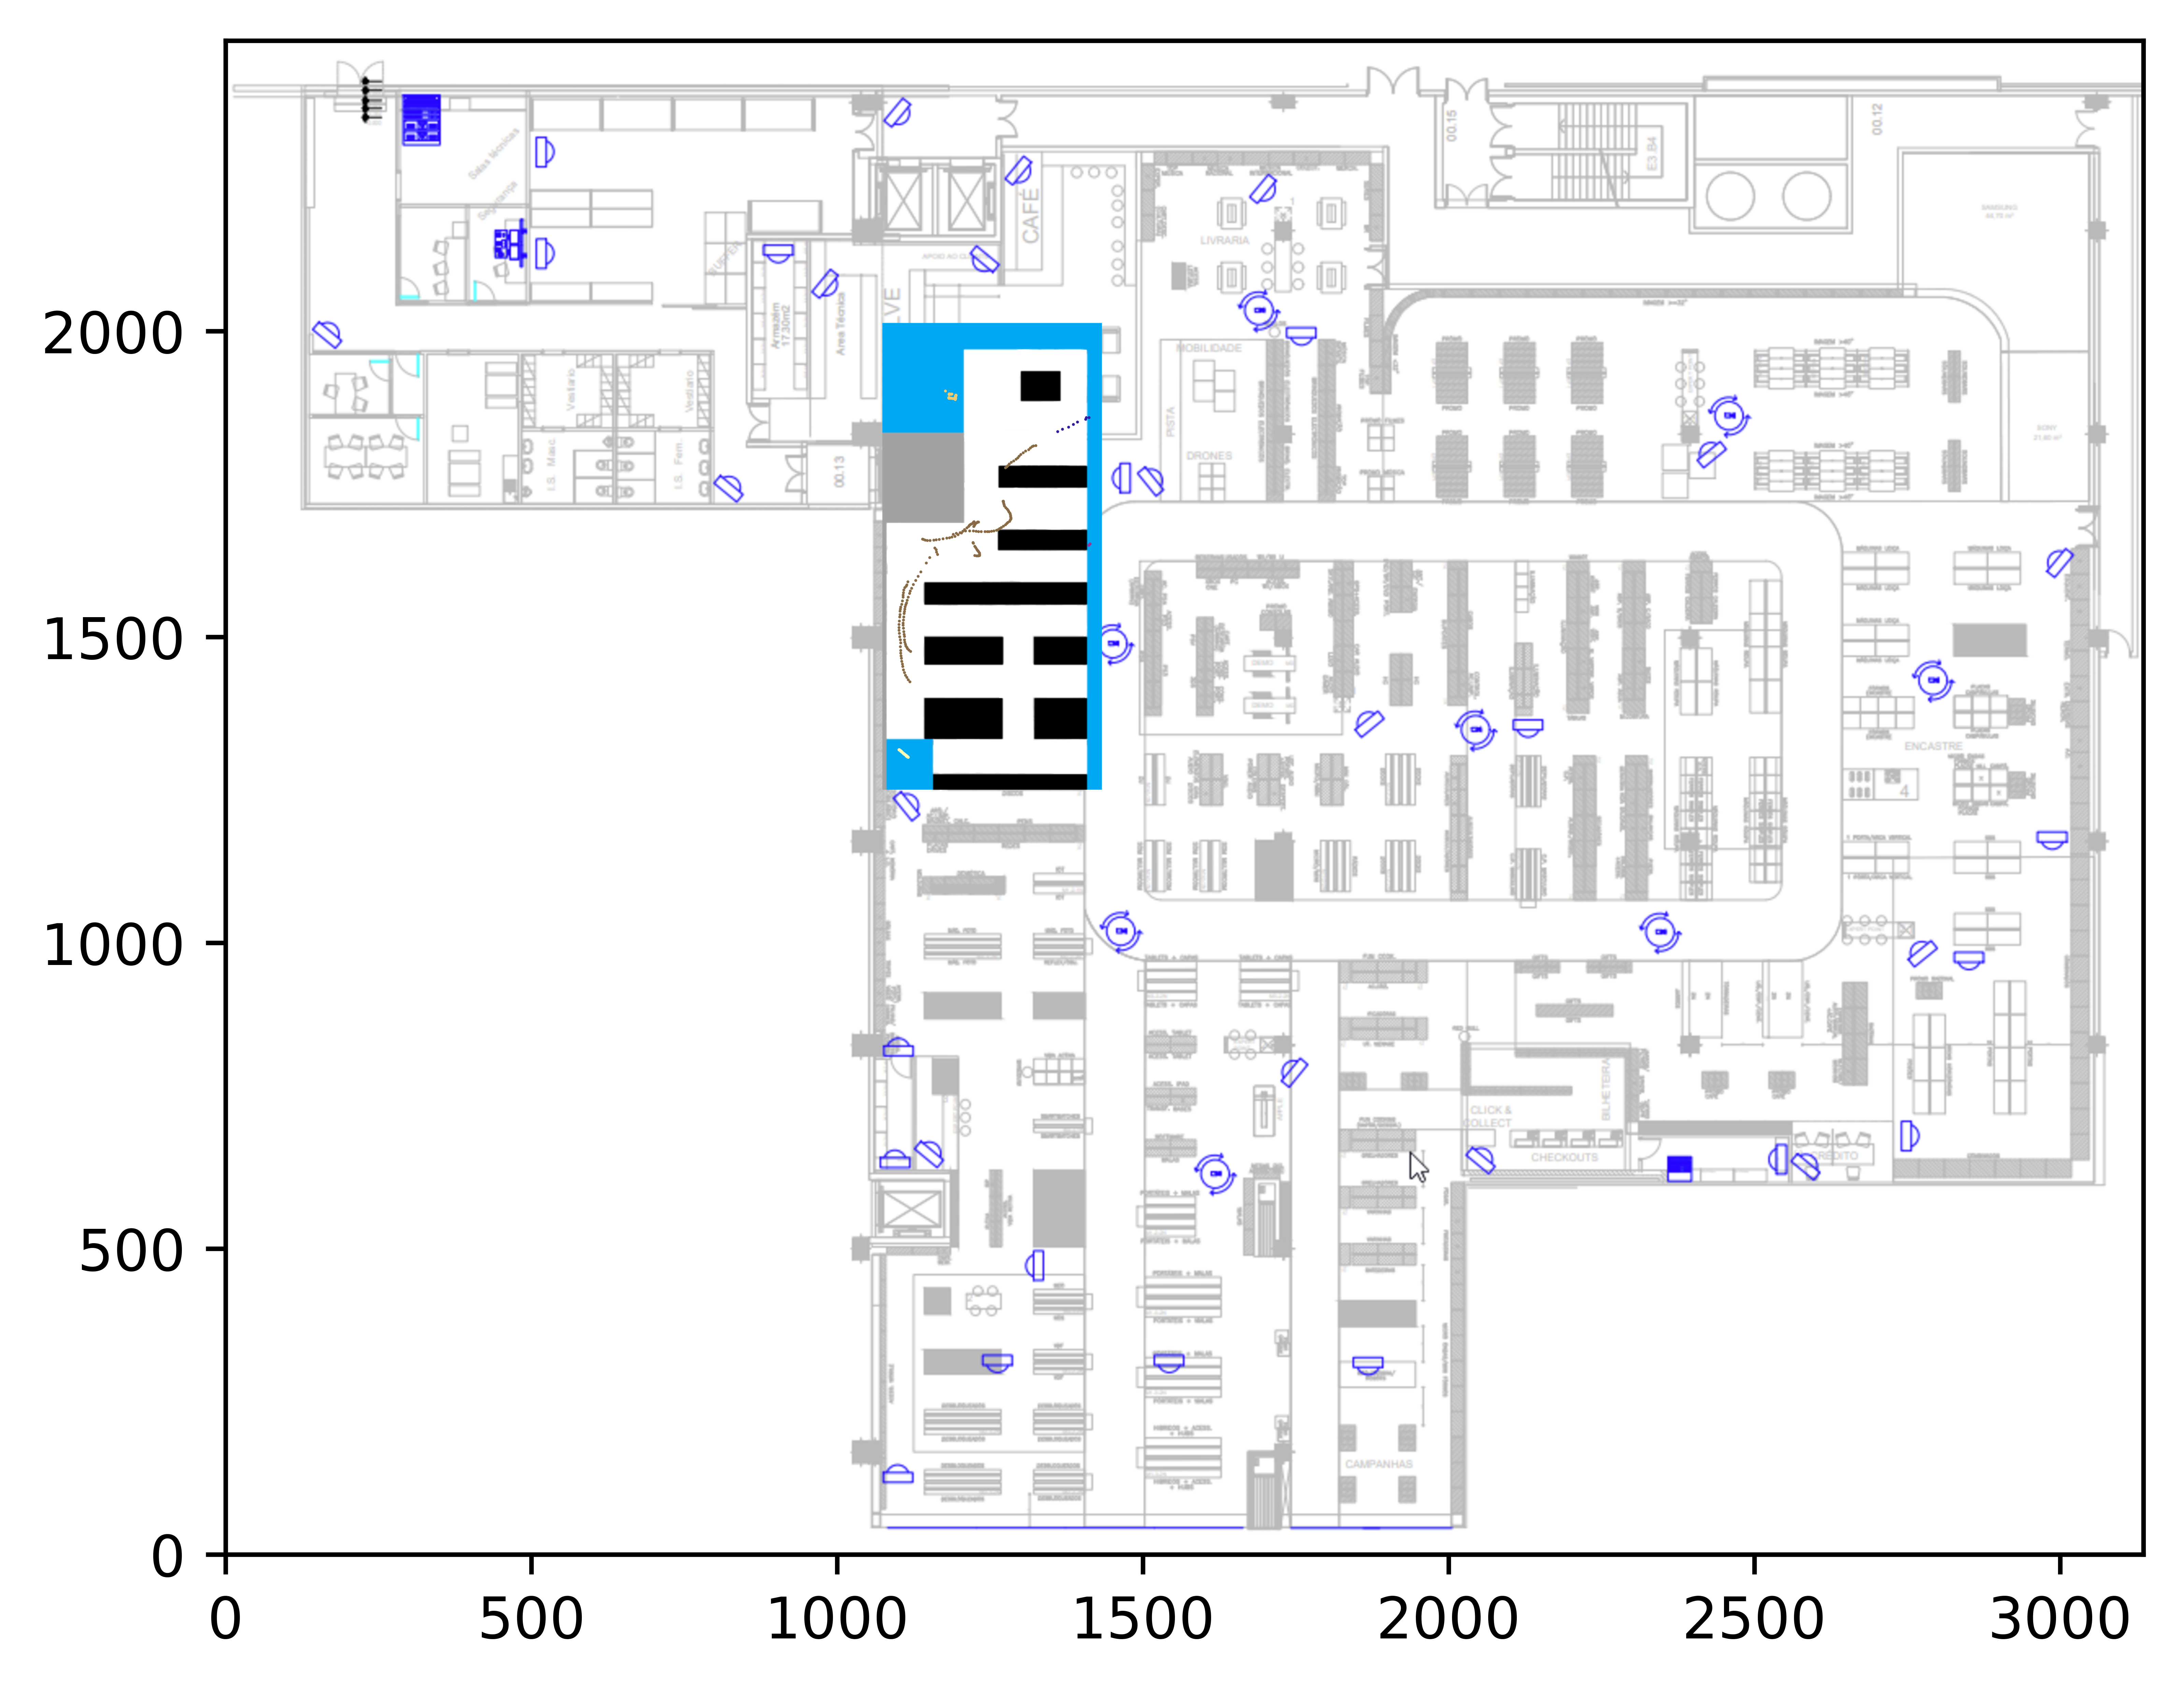

In [12]:
df = pd.read_csv(f"{TRAJECTORY_EXAMPLE_PATH}example_{EXAMPLE_NUMBER}.csv", low_memory=False, index_col=None, header=0)
df_filtered = get_data_reid_area(df)
df_filtered = remove_false_positive_data(df_filtered)
df_filtered = remove_data_occlusion_area(df_filtered)
df_filtered = re_id_customers_close_points(df_filtered, DISTANCE_CLOSE, TIME_INTERVAL_CLOSE)
df_filtered = re_id_customers_last_and_first_points(df_filtered, TIME_INTERVAL)
df_filtered.to_csv(f"{TRAJECTORY_EXAMPLE_PATH}result_{EXAMPLE_NUMBER}.csv", index=False)
print_trajectory(df_filtered)
print_info(df, df_filtered, INFO_SAVE_PATH)

In [13]:
print(len((df["customer_id_global"].unique())))
print(len((df_filtered["customer_reid"].unique())))

32
5
